In [21]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import sys,os
import pickle
from eknot_utils import EventNode,NodeParams,printSummaryOne
from utils import loadPickle,triHits,norm2,printTopWords,coHits,lexRank,norm1
from eknot_utils import *
from time import time

i=50
[resDocInd,tweetsObj,tweetsObjDedup,tweetsScore]= loadPickle('../output/summary_20160207_0213_70_'+str(i)+'.pickle')
[Xs,vects,DT,ind2obj] = loadPickle('../data/20160207_0213.pickle')
rootParams,rootNodeDescriptor = loadPickle('../output/plsa_20160207_0213_70.pickle')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
window = 7
topK = 100 # ent used
t0 = time()
Pw_zs = rootNodeDescriptor.Pw_zs
Pe_z = Pw_zs[1][:,i]
evocab = vects[5].get_feature_names()
vocab = vects[0].get_feature_names()

ent_ind,ents = getEntInd(evocab,Pe_z,topK)

print( "entscore in "+str(time() - t0))
t0 = time()

newsObj = [ind2obj[n] for n in resDocInd]
XN,XEn,NEb,sentencesIn,sentencesInObj,ent_text_n = getNewsContext(newsObj,ent_ind,ents,vocab,window)
print( "get news Context in "+str(time() - t0))
print len(newsObj),len(sentencesIn),len(set(sentencesIn))
t0 = time()

XT,XEt,TEb,tweetsIn,tweetsInObj,ent_text_t = getTweetContext(tweetsObjDedup,ent_ind,ents,vocab,window)
print( "get tweet Context in "+str(time() - t0))

print len(tweetsObjDedup),len(tweetsIn),len(set(tweetsIn))
print XEn.shape,Pe_z.shape

entscore in 0.0193240642548
get news Context in 1.51942706108
43 1474 1467
append in 2.07374596596
vectorize in 10.8675408363
ents append + vec in 1.09330296516
get tweet Context in 14.0429599285
15576 15564 15564
(100, 15042) (4947,)


In [16]:
Pz_d = rootNodeDescriptor.Pz_d
Pd = rootNodeDescriptor.Pd
ilist = Pz_d.dot(Pd).argsort()[::-1][1:26]
print Pz_d.dot(Pd).argsort()[::-1]
len(ilist),ilist

[70 37 50 60 29 16  2 15  0  9 68 67 44 11  7 14  5 17  4 36 38 59 35 28 40
 18 57 46  3 22 55 24 20 32  6 58 25 34  8 45 30 43 31 41 56 26 39 62 61 63
 53 52 27 66 47 42 33 54 23 19  1 21 69 51 13 10 48 65 12 49 64]


(25, array([37, 50, 60, 29, 16,  2, 15,  0,  9, 68, 67, 44, 11,  7, 14,  5, 17,
         4, 36, 38, 59, 35, 28, 40, 18]))

In [41]:

# #####
# rows = []
# interestedEnts = ['gun_control_other_|','income_tax_other_|','immigration_other_|']
# interestedEnts = ['gun_control_other_|']
# interestedEnts = ents[4:]
# for e in interestedEnts:
#     rows.append(ent_ind[e])
# rows = np.array(rows)
# #rows = np.array([10,33,34,40])
# XEn = _XEn[rows,:]
# XEt = _XEt[rows,:]
# NEb = _NEb[:,rows]
# TEb = _TEb[:,rows]
# #####



t0 = time()

newsScore = XN.dot(Pw_zs[0][:,i])

tweetsScore = XT.dot(Pw_zs[0][:,i])
#tweetsScore = []
#for t in tweetsInObj:
#    tweetsScore.append(float(t.pop))
#tweetsScore = np.array(tweetsScore)

print( "init score in "+str(time() - t0))
t0 = time()

NE_ = XN.dot(XEn.T) #.multiply(NEb)
TE_ = XT.dot(XEt.T) #.multiply(TEb)

##### weight by pop
TE_indptr = TE_.indptr
TE_data = TE_.data
for (XTid,t) in enumerate(tweetsInObj):
    st = TE_indptr[XTid]
    en = TE_indptr[XTid+1]
    TE_data[st:en]*=float(t.pop)
#####

NE,EN = normBypartite(NE_)
TE,ET = normBypartite(TE_)
print( "graph constr in "+str(time() - t0))
t0 = time()

#nScore, tScore = triHits(newsScore, tweetsScore, NE, EN, TE, ET, 1, 1, 5)
#print( "trihits in "+str(time() - t0))



########### params ############
passes = 100
wN = 0.7
wT = 0.7
######### tri hits #########
nScore, tScore = triHits(newsScore, tweetsScore, NE, EN, TE, ET, wN,wT, passes)
#nScore, tScore = triHits(np.ones(newsScore.shape), np.ones(tweetsScore.shape), NE, EN, TE, ET, 1, 1, 50)
print np.linalg.norm(norm2(newsScore)[:10] - nScore[:10])
#print "========="
#kSummary=5
#printSummary(norm2(newsScore),norm2(tweetsScore),sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
#print "*****"
#printSummary(nScore,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)

######## tri_n ################
entsScore = XEn.dot(Pw_zs[0][:,i])
#printRankedEnt(entsScore,ents,100,DISPLAY=True)
nScore_tri_n, eScore = coHits(newsScore, entsScore, NE, EN, wN, wT, passes)
#printSummary(nScore_tri_n,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,5)
#########################

############ lexrank ####################
NN = normalize(XN.dot(XN.T),axis=1,norm='l1')
nScore_lex = lexRank(newsScore,NN,passes=200)
#printSummary(nScore_lex,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,10)
####################################

#############co-hits#######################
NT = normalize(XN.dot(XT.T),axis=1,norm='l1')
TN = normalize(XT.dot(XN.T),axis=1,norm='l1')
nScore_co,tScore_co = coHits(newsScore,tweetsScore,NT,TN,wN,wT,passes)
#printSummary(nScore_co,tScore_co,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,10)
#########################################

################# rank ents ####################
_res1 = printRankedEnt(NE.T.dot(newsScore),ents,topK)
res1 = printRankedEnt(NE.T.dot(nScore),ents,topK)
res2 = printRankedEnt(NE.T.dot(nScore_lex),ents,topK)
res3 = printRankedEnt(NE.T.dot(nScore_co),ents,topK)
res4 = printRankedEnt(NE.T.dot(nScore_tri_n),ents,topK)

# _res2 = printRankedEnt(TE.T.dot(tweetsScore),ents,100)
# res2 = printRankedEnt(TE.T.dot(tScore),ents,100)

for e in ents[:20]:
    #print res1[e],_res1[e],res2[e],_res2[e],'>|<',res1[e]-_res1[e],res2[e]-_res2[e], res2[e] - res1[e],e
    print res1[e] - res2[e],res3[e] - res2[e],res1[e]-res4[e],res3[e]-res4[e],\
        '\t|',res1[e],res2[e],res3[e],res4[e],_res1[e],\
        '\t|',res1[e]-_res1[e],res2[e]-_res1[e],res3[e]-_res1[e],res4[e]-_res1[e],\
        '\t|',res2[e] - res4[e],e

print "##############"        

printRankedEnt(NE.T.dot(nScore),ents,100,DISPLAY=True)

init score in 0.000930070877075
graph constr in 0.157219171524
==t converge 5 3.47773667512e-10
0.119877799349
==n converge 9 2.80121802644e-10
==n converge 105 9.56740593984e-10
==e converge 6 3.52195901355e-10
0 0 0 0 	| 0 0 0 0 0 	| 0 0 0 0 	| 0 hillary_rodham_clinton_per_|
1 -1 0 -2 	| -3 -4 -5 -3 -4 	| 1 0 -1 1 	| -1 democratic_party_(united_states)_org_|
0 0 0 0 	| 1 1 1 1 1 	| 0 0 0 0 	| 0 bill_clinton_per_|
-2 -1 0 1 	| -3 -1 -2 -3 -3 	| 0 2 1 0 	| 2 new_hampshire_primary_other_|
-1 -1 0 0 	| -5 -4 -5 -5 -5 	| 0 1 0 0 	| 1 barack_obama_per_|
1 -1 0 -2 	| -5 -6 -7 -5 -7 	| 2 1 0 2 	| -1 south_carolina_loc_|
-1 -3 0 -2 	| -8 -7 -10 -8 -10 	| 2 3 0 2 	| 1 african_american_other_|
0 0 0 0 	| 5 5 5 5 5 	| 0 0 0 0 	| 0 bernie_sanders_per_|
0 -2 0 -2 	| -21 -21 -23 -21 -24 	| 3 3 1 3 	| 0 wall_street_loc_|
1 2 0 1 	| -9 -10 -8 -9 -8 	| -1 -2 0 -1 	| -1 political_action_committee_other_|
0 -1 0 -1 	| 3 3 2 3 2 	| 1 1 0 1 	| 0 democracy_other_|
1 4 1 4 	| -5 -6 -2 -6 -3 	| -2 -3 1 -3 	|

{u'activism_other_|': -13,
 u'african-american_civil_rights_movement_(1955-68)_other_|': -55,
 u'african_american_other_|': -8,
 u'al_sharpton_per_|': 36,
 u'barack_obama_per_|': -5,
 u'bernie_sanders_per_|': 5,
 u'bill_clinton_per_|': 1,
 u'campaign_finance_other_|': 37,
 u'carly_corinthos_per_|': -20,
 u'caucus_other_|': 5,
 u'charleston,_south_carolina_loc_|': -15,
 u'civil_and_political_rights_other_|': -27,
 u'classified_information_other_|': -26,
 u'clinton_foundation_org_|': 4,
 u'cnn_org_|': -3,
 u'coalition_other_|': 25,
 u'community_college_other_|': -13,
 u'congressional_black_caucus_org_|': 7,
 u'criminal_justice_other_|': -24,
 u'david_brock_per_|': 25,
 u'democracy_other_|': 3,
 u'democratic_national_committee_org_|': -7,
 u'democratic_party_(united_states)_org_|': -3,
 u'demographics_other_|': -1,
 u'economic_inequality_other_|': -21,
 u'education_other_|': 18,
 u'email_other_|': 10,
 u'exit_poll_other_|': 28,
 u'feminism_other_|': -34,
 u'foreign_policy_other_|': -39,
 

In [47]:
kSummary = int(np.log(len(set(sentencesIn))))
print kSummary
b=0.25
print '########### lex rank ##############'
#printSummary(nScore_lex,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
printSummaryOne(nScore_lex,sentencesIn,sentencesInObj,XN,kSummary,b)

print '########### tri graph ##############'
#printSummary(nScore,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
printSummaryOne(nScore,sentencesIn,sentencesInObj,XN,kSummary,b)
print '##### tweets ####'
printSummaryOne(tScore,tweetsIn,tweetsInObj,XT,2*kSummary,b)

7
########### lex rank ##############
 bill clinton unloads on  bernie sanders -- ahead of crucial  new hampshire primary
 has the  democratic race become a referendum on  bernie sanders, not  hillary clinton?
 following a stinging loss in  new hampshire this week, the  clinton campaign and priorities  usa, the " super pac" that supports her, have sharpened their focus on mr. sanders and the  south carolina  democratic primary on feb. 27.
 "you had a very pointed, some would say divisive, campaign in 2008 between  barack obama and  hillary clinton, and ultimately  barack obama was elected president and he asked  hillary clinton to be his secretary of state," she pointed out.
 a question for  clinton is whether she can use what is looking to be an extended primary campaign against sanders to energize women for the  general election should she win the nomination.
 as if to prove the point, the sanders campaign issued a news release friday with this headline: " clinton wall street-funded 

In [8]:
################# rank words ####################
wtopK=len(vocab)
_res1 = printRankedEnt(XN.T.dot(newsScore),vocab,wtopK)
res1 = printRankedEnt(XN.T.dot(nScore),vocab,wtopK)
res2 = printRankedEnt(XN.T.dot(nScore_lex),vocab,wtopK)
res3 = printRankedEnt(XN.T.dot(nScore_co),vocab,wtopK)
res4 = printRankedEnt(XN.T.dot(nScore_tri_n),vocab,wtopK)

# _res2 = printRankedEnt(TE.T.dot(tweetsScore),ents,100)
# res2 = printRankedEnt(TE.T.dot(tScore),ents,100)
print i
for k in Pw_zs[0][:,i].argsort()[::-1][:topK]:
    e = vocab[k]
    #print res1[e],_res1[e],res2[e],_res2[e],'>|<',res1[e]-_res1[e],res2[e]-_res2[e], res2[e] - res1[e],e
    print res1[e] - res2[e],res3[e] - res2[e],res1[e]-res4[e],res3[e]-res4[e],\
        '\t|',res1[e],res2[e],res3[e],res4[e],_res1[e],\
        '\t|',res1[e]-_res1[e],res2[e]-_res1[e],res3[e]-_res1[e],res4[e]-_res1[e],\
        '\t|',res2[e] - res4[e],e

print "##############"        
printRankedEnt(XN.T.dot(nScore),vocab,topK,DISPLAY=True)

25
0 0 0 0 	| 13381 13381 13381 13381 13381 	| 0 0 0 0 	| 0 tamir
0 -1 0 -1 	| 11493 11493 11492 11493 11493 	| 0 0 -1 0 	| 0 rice
0 1 0 1 	| 2899 2899 2900 2899 2899 	| 0 0 1 0 	| 0 cleveland
-4 -7 -3 -6 	| 8144 8148 8141 8147 8147 	| -3 1 -6 0 	| 1 loehmann
1 1 0 0 	| 5345 5344 5345 5345 5344 	| 1 0 1 1 	| -1 family
1 1 0 0 	| 2848 2847 2848 2848 2847 	| 1 0 1 1 	| -1 claim
2 3 1 2 	| 1060 1058 1061 1059 1060 	| 0 -2 1 -1 	| -1 ambulance
-1 -2 0 -1 	| 2843 2844 2842 2843 2844 	| -1 0 -2 -1 	| 1 city
0 0 1 1 	| 5045 5045 5045 5044 5045 	| 0 0 0 -1 	| 1 estate
3 5 2 4 	| 52 49 54 50 51 	| 1 -2 3 -1 	| -1 $500
-2 -5 -2 -5 	| 10168 10170 10165 10170 10167 	| 1 3 -2 3 	| 0 police
0 0 -1 -1 	| 5488 5488 5488 5489 5487 	| 1 1 1 2 	| -1 filed
1 0 0 -1 	| 2120 2119 2119 2120 2120 	| 0 -1 -1 0 	| -1 boy
-2 -2 0 0 	| 9384 9386 9384 9384 9385 	| -1 1 -1 -1 	| 2 officer
-2 -1 -1 0 	| 12227 12229 12228 12228 12230 	| -3 -1 -2 -2 	| 1 shot
0 0 0 0 	| -2742 -2742 -2742 -2742 -2742 	| 0 0 0 0 	| 0 bi

{u'$450': -35,
 u'$500': 52,
 u'12': 139,
 u'2014': 280,
 u'added': 628,
 u'advance': 696,
 u'affiliate': 743,
 u'ambulance': 1060,
 u'apologized': 1129,
 u'asking': 1305,
 u'attorney': 1448,
 u'behavior': 1764,
 u'bills': 1871,
 u'boy': 2120,
 u'breathtaking': 2097,
 u'callousness': 2333,
 u'case': 2484,
 u'center': 2564,
 u'chandra': 2647,
 u'city': 2843,
 u'claim': 2848,
 u'cleveland': 2899,
 u'conference': 3170,
 u'cop': 3371,
 u'cost': 3412,
 u'county': 3491,
 u'court': 3529,
 u'creditor': 3576,
 u'cuyahoga': 3684,
 u'day': 3789,
 u'death': 3841,
 u'decedent': 3789,
 u'director': 4174,
 u'disturbed': 4368,
 u'dying': 4593,
 u'emergency': 4779,
 u'estate': 5045,
 u'expense': 5159,
 u'family': 5345,
 u'fatally': 5352,
 u'federal': 5350,
 u'fees': 5386,
 u'filed': 5488,
 u'files': 5429,
 u'frank': 5773,
 u'garmback': 5886,
 u'grand': 6095,
 u'gun': 6255,
 u'hospital': 6693,
 u'insensitivity': 7115,
 u'invoice': 7282,
 u'jackson': 7368,
 u'judgment': 7507,
 u'jury': 7511,
 u'killed': 

875
19 1.57886296884 earthquake
61 1.46427921992 rubble
62 1.44591231759 lin
97 1.44351716785 tuesday
89 1.42183996955 death
35 1.35799148253 toppled
53 1.33841039573 powerful
58 1.33529966424 southern
0 1.31738032482 taiwan
34 1.26471005716 days
78 1.25887204561 developer
77 1.25738837684 built
31 1.22745789188 apartment
9 1.21658367914 survivors
33 1.19133551313 complex
57 1.18363041322 high-rise
82 1.15531217888 4
60 1.15137006822 workers
32 1.13790842604 rescue
46 1.12691852343 construction
39 1.11104305983 earthquakes
29 1.10949321354 17
4 1.10693653324 tainan
2 1.09688891322 building
83 1.09554451647 6.4
76 1.08961319206 weiguan
86 1.08684471506 magnitude
28 1.0817923407 story
22 1.07692240201 collapse
1 1.07495884309 quake
51 1.07420483205 rattle
21 1.06936699815 saturday
7 1.04826399006 pulled
30 1.04074654175 frequently
44 1.03653330841 missing
41 1.03177425562 rescuers
50 1.02518815671 1999
52 1.01781873415 buildings
37 1.01331720388 golden
36 1.01331720388 dragon
5 1.0094768

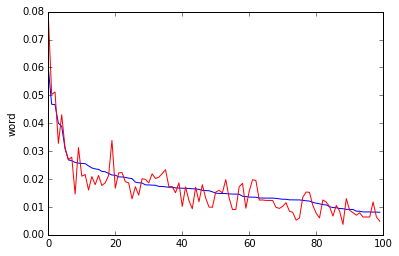

In [167]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
w_lex = XN.T.dot(nScore_lex)
w_tri = XN.T.dot(nScore)
N = min(sum(w_lex!=0),sum(w_tri!=0))
print N
wind = w_lex.argsort()[::-1][:100]
w_lex_ = np.array([w_lex[k] for k in wind])
w_tri_ = np.array([w_tri[k] for k in wind])


rate = w_tri_/w_lex_
#ate = np.array([w_tri_[k]/w_lex_[k] if w_tri_[k] /w_lex_[k]>1 else w_lex_[k]/w_tri_[k] for k in range(len(w_tri_))])
rind = rate.argsort()[::-1][:100]
for k in rind:    
    print k,w_tri_[k]/w_lex_[k],vocab[wind[k]]
plt.plot(range(len(wind)),w_lex_,'b',w_tri_,'r')
#plt.plot(range(len(wind)),np.log(w_lex_),'b',np.log(w_tri_),'r')
plt.ylabel('word')

fig = plt.gcf()
fig.savefig('/home/jwang112/Dropbox/linux_buffer/figs/test3.png',bbox_inches='tight')

#plt.show()

i=18
res0 = printRankedEnt(Pw_zs[0][:,i],vocab,20,DISPLAY=True)

125
18 1.25407754454 taipei_loc_|
17 1.21059312921 tin_can_other_|
5 1.12917235776 quake_(video_game)_other_|
8 1.12250056426 earthquake_other_|
0 1.10901701914 taiwan_loc_|
2 1.0601749804 apartment_other_|
14 1.03935975692 rubble_other_|
9 1.03510430609 moment_magnitude_scale_other_|
4 1.03019070192 tower_block_other_|
6 0.995932437614 richter_magnitude_scale_other_|
1 0.972111594861 tainan_loc_|
7 0.963914826726 survivor_(band)_org_|
13 0.953102628387 channel_newsasia_org_|
19 0.940641552354 ma_ying-jeou_per_|
10 0.892359569888 korean_central_news_agency_other_|
11 0.81512291066 beam_(structure)_other_|
15 0.770515216109 chinese_new_year_other_|
12 0.751615708667 8-bit_other_|
16 0.73739639022 chinese_calendar_other_|
3 0.503427490187 family_other_|


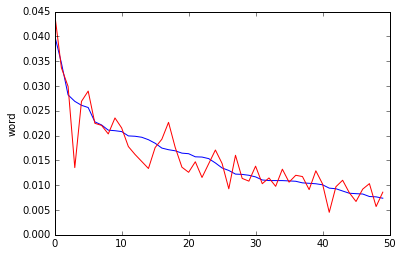

===
4331 4331 0.159723413312 taiwan_loc_|
4327 4328 0.0854238629487 tainan_loc_|
837 839 0.0331977777499 chinese_new_year_other_|
4511 4514 0.0274095489304 tower_block_other_|
1365 1369 0.0260080246753 earthquake_other_|
1543 1548 0.0242481389399 family_other_|
782 788 0.0207455579786 channel_newsasia_org_|
3730 3737 0.0197146651447 richter_magnitude_scale_other_|
2440 2448 0.0186041057556 korean_central_news_agency_other_|
18 27 0.0183060506194 8-bit_other_|
826 836 0.0166777799683 chinese_calendar_other_|
4274 4285 0.0157540696509 survivor_(band)_org_|
2883 2895 0.0154955148519 moment_magnitude_scale_other_|
219 232 0.0152295383059 apartment_other_|
4470 4484 0.014768226693 tin_can_other_|
408 423 0.0142253979387 beam_(structure)_other_|
3594 3610 0.0141746332913 quake_(video_game)_other_|
4312 4329 0.0134762226491 taipei_loc_|
3781 3799 0.0133451537923 rubble_other_|
2641 2660 0.0128308146411 ma_ying-jeou_per_|


In [179]:
kprint = 20
indsmall=[]
for e in ents[:kprint]:
    indsmall.append(ent_ind[e])
indsmall = np.array(indsmall)    
NEsmall = NE[:,indsmall]

kplot=50
e_lex = NE.T.dot(nScore_lex)
e_tri = NE.T.dot(nScore)
N = min(sum(e_lex!=0),sum(e_tri!=0))
print N
eind = e_lex.argsort()[::-1][:kplot]
e_lex_ = np.array([e_lex[k] for k in eind])
e_tri_ = np.array([e_tri[k] for k in eind])

plt.plot(range(len(eind)),e_lex_,'b',e_tri_,'r')
#plt.plot(range(len(wind)),np.log(w_lex_),'b',np.log(w_tri_),'r')
plt.ylabel('word')

fig = plt.gcf()
fig.savefig('/home/jwang112/Dropbox/linux_buffer/figs/test1.png',bbox_inches='tight')


e_lex_small = e_lex[indsmall]
e_tri_small = e_tri[indsmall]
eindsmall = e_lex_small.argsort()[::-1]
e_lex_small_ = np.array([e_lex_small[k] for k in eindsmall])
e_tri_small_ = np.array([e_tri_small[k] for k in eindsmall])

rate = e_tri_small_/e_lex_small_
#ate = np.array([w_tri_[k]/w_lex_[k] if w_tri_[k] /w_lex_[k]>1 else w_lex_[k]/w_tri_[k] for k in range(len(w_tri_))])
rind = rate.argsort()[::-1]
for k in rind:    
    print k,e_tri_small_[k]/e_lex_small_[k],ents[indsmall[eindsmall[k]]]

plt.show()
print "==="
i=18
res0 = printRankedEnt(Pw_zs[1][:,i],evocab,20,DISPLAY=True)

In [190]:
ent_text_n['survivor_(band)_org_|']

' survivors pulled out from survivors found, but dozens survivors pulled from rubble'